# Titanic
We will be interested in the impact of factors conditioning the survival of the Titanic disaster on the level of individual passengers. We will examine the influence of predecessors such as: gender, deck class assigned to the passenger or port of departure.

In [1]:
import os
import pandas as pd

def load_data(filename, path):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

The data set is already divided into training data (`train.csv`) and test data (`test.csv)

In [2]:
train_data = load_data("train.csv", "data")
test_data = load_data("test.csv", "data")

The data are from [Kaggle](https://www.kaggle.com/c/titanic), so it does not contain labels - the verification of the model's correctness will be carried out by submitting predictions to the Kaggle portal.

### Data preprocessing
Let's see what the data structure looks like

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Attributes have the following meaning:
* **Survived** (survived): this is our target class; 0 means that the passenger did not survive and 1 means that he survived.
* **Pclass** (class): passenger class.
* **Name**, **Sex**, **Age** (name), (sex), (age): need no explanation.
* **SibSp** (siblings and partners): number of passenger siblings and partners present on the ship.
* **Parch** (ascendants and descendants): number of children and parents of a passenger present on board the ship.
* **Ticket** (ticket): Ticket ID.
* **Fare** (fare): price paid for the journey (in pounds).
* **Cabin** (cabin): passenger's cabin number.
* **Embarked**: Titanic boarding point.

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We have 891 passengers at our disposal. Most attributes contain full information, but there are also those that have missing observations (`Age`, `Cabin`, `Embarked`).

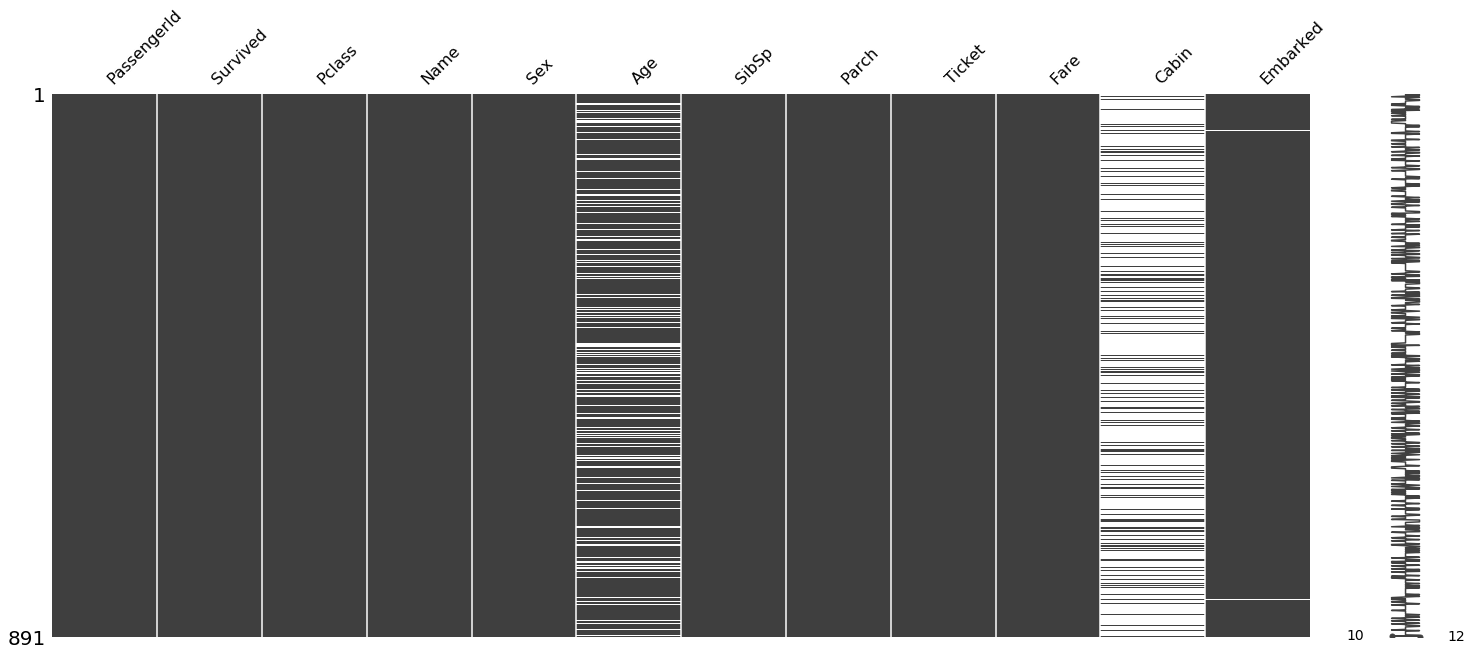

In [5]:
import missingno as msno

msno.matrix(train_data)

The `Embarked` attribute only contains a few missing observations - this is not a big problem. In the case of the `Age` attribute we have a significant part of the missing data - in this case we will add the median age of all passengers in the training set. The last attribute - `Cabin` - contains less than 30% of the data, so we can ignore it in the first approach

Note also that the name of the ticket (`Ticket`) and the name of the passenger (`Name`) from the model point of view are not informative and therefore will not be taken into account further

In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


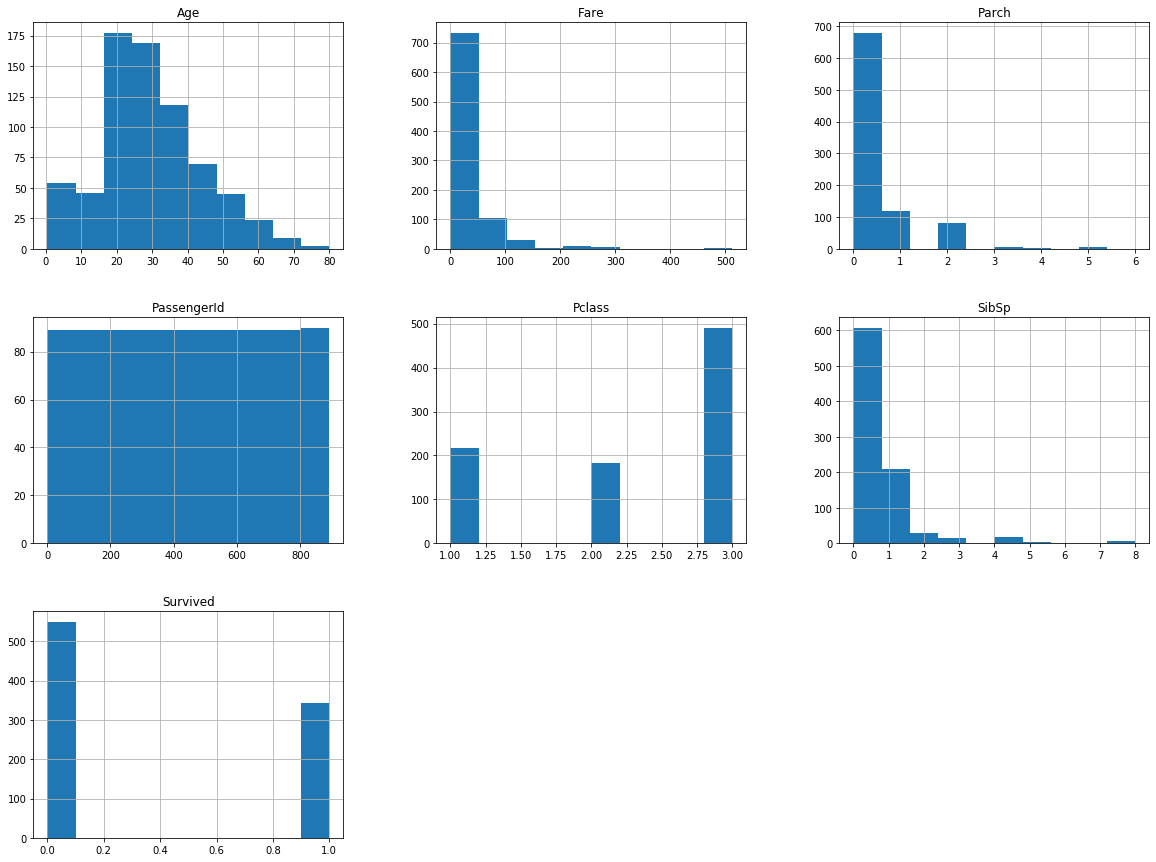

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

train_data.hist(figsize=(20,15))
plt.show()

Let's note that slightly less than 40 % of passengers survived the crash. It can therefore be said that the size of both classes is similar and standard metrics (such as accuracy) are used.

From histograms you can also find out which of the available numerical attributes we should rather treat as categorical. They are:
* `Survived`
* `Pclass`
* `Sex`
* `Embarked`

In [8]:
cat_features = ["Survived", "Pclass", "Sex", "Embarked"]

for feature in cat_features:
    print(feature,":\n",train_data[feature].value_counts())

Survived :
 0    549
1    342
Name: Survived, dtype: int64
Pclass :
 3    491
1    216
2    184
Name: Pclass, dtype: int64
Sex :
 male      577
female    314
Name: Sex, dtype: int64
Embarked :
 S    644
C    168
Q     77
Name: Embarked, dtype: int64


Let us also note that none of the above features have a natural order. Additionally, all of them contain few classes, so it is most convenient to transform them with the use of hot one-zero encoding. Let us also note that none of the above features have a natural order. Additionally, they all contain few classes, so it is most convenient to transform them with hot-zero-one coding. For this we can use a ready-made class (copied from [Pull Request #9151](https://github.com/scikit-learn/scikit-learn/pull/9151/commits))

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
import numpy as np

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("Choose one of the following encodings: 'onehot', 'onehot-dense' "
                        "or 'ordinal', you choose %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("Choose one of the following values of the handle_unknown parameter: 'error' or "
                        "'ignore'', you choose %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("The value handle_unknown='ignore' is not supported by the parameter"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Unknown categories are found {0} in column {1}'."
                               " during fitting".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Unknown categories are found {0} in column {1}'."
                           " during conversion".format(diff, i))
                    raise ValueError(msg)
                else:
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

For the convenience of using pipelines, we will create a class that supports a selection of features to be taken into account when teaching the model

In [10]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes]

Let's create a pipeline for numerical attributes

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy="median"))
])

In [12]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

The categorical features need a separate pipeline (e.g. due to a different way of completing missing data and the need for coding)

In [13]:
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", CategoricalEncoder(encoding="onehot-dense"))
])

In [14]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [15]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [16]:
X = preprocess_pipeline.fit_transform(train_data)
X

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

We are still creating a vector of corresponding labels 

In [17]:
y = train_data["Survived"]
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

### Model learning

In the first approach, we can start with the support vector machine

In [18]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X,y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Note that through the code below we can already generate results for the test set, however, verification would each time require generating a file `csv` and submitting to the kaggle service

In [19]:
X_test = preprocess_pipeline.transform(test_data)
y_predict = svm_clf.predict(X_test)

This approach is impractical at the model building stage. However, we can get around this by using crossvalidation

In [22]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_clf, X, y, cv=10)
scores.mean()

0.6813233458177278

An accuracy of 68% is not the pinnacle of our ambition (although it is still better than a random classifier). To start with, let's consider if another model is not more suitable for this task

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
scores = cross_val_score(forest_clf, X, y, cv=10)
scores.mean()

0.8126466916354558